In [ ]:
!pip3 install keras

In [ ]:
!wget https://www.dropbox.com/s/zcwlujrtz3izcw8/gender.tgz
!tar xvzf gender.tgz

--2022-03-26 10:47:09--  https://www.dropbox.com/s/zcwlujrtz3izcw8/gender.tgz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6022:18::a27d:4212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/zcwlujrtz3izcw8/gender.tgz [following]
--2022-03-26 10:47:09--  https://www.dropbox.com/s/raw/zcwlujrtz3izcw8/gender.tgz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7043cadff021f6d80a43480121.dl.dropboxusercontent.com/cd/0/inline/BiOM0c13SVlZABT7HdTCETazUX5X6q6mw6R6dL8iKMjK8BUKKysamvqlqYFP9vM9vup7Bx29bDVf6sGwFUWbcKD68QMaeQ69wrFRiVzB4LzdKkjtNbDLFezuQxSv9TzZt_rfthAyOzaNDUxGJwo6rX1ZGLzmp9hwgHOuFNF6Tb77Dg/file# [following]
--2022-03-26 10:47:10--  https://uc7043cadff021f6d80a43480121.dl.dropboxusercontent.com/cd/0/inline/BiOM0c13SVlZABT7HdTCETazUX5X6q6mw6R6dL8iKMjK8BUKKysamvqlqYFP9vM9vup7Bx29b

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function
import keras
import tensorflow
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Add, Input, AveragePooling2D
from keras.layers import BatchNormalization as BN
from keras.layers import GaussianNoise as GN
from tensorflow.keras.optimizers import Adam

from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

(10585, 100, 100, 3)
(10585,)
2381
8204
0.2249
(2648, 100, 100, 3)
(2648,)
596
2052
0.2251


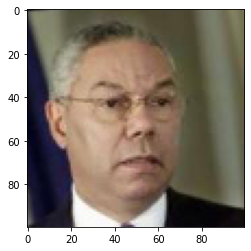

(10585, 100, 100, 3)
(2648, 100, 100, 3)


In [ ]:
# Load 
x_train = np.load('x_train.npy')
x_test = np.load('x_test.npy')

y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

# Stats
print(x_train.shape)
print(y_train.shape)
print(sum(y_train == 1))
print(sum(y_train == 0))
print("{:.4f}".format(sum(y_train == 1)/y_train.shape[0]))
print(x_test.shape)
print(y_test.shape)
print(sum(y_test == 1))
print(sum(y_test == 0))
print("{:.4f}".format(sum(y_test == 1)/y_test.shape[0]))


## View some images
plt.imshow(x_train[0,:,:,: ] )
plt.show()


## Transforms
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')


x_train /= 255
x_test /= 255

print(x_train.shape)
print(x_test.shape)


num_classes = 2

y_train = tensorflow.keras.utils.to_categorical(y_train, num_classes)
y_test = tensorflow.keras.utils.to_categorical(y_test, num_classes)

# Model 1: convolutional network with data augmentation

In [ ]:
datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True)

## DEF A BLOCK CONV + BN + GN + MAXPOOL
def CBGN(model,filters,ishape=0):
  if (ishape!=0):
    model.add(Conv2D(filters, (3, 3), padding='same',
                 input_shape=ishape))
  else:
    model.add(Conv2D(filters, (3, 3), padding='same'))
  
  model.add(BN())
  model.add(GN(0.3))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  return model

## DEF NN TOPOLOGY  
model = Sequential()
model=CBGN(model,32,x_train.shape[1:])
model=CBGN(model,64)
model=CBGN(model,128)
model=CBGN(model,256)
model=CBGN(model,512)

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()



## OPTIM AND COMPILE
opt = Adam(learning_rate=0.01)

# PARAMETERS
batch_size=256
epochs=80

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# DEFINE A LEARNING RATE SCHEDULER
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001)

## TRAINING with DA and LRA
history=model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                            steps_per_epoch=len(x_train) / batch_size, 
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            callbacks=[reduce_lr],
                            verbose=1)


## TEST
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 100, 100, 32)     128       
 ormalization)                                                   
                                                                 
 gaussian_noise (GaussianNoi  (None, 100, 100, 32)     0         
 se)                                                             
                                                                 
 activation (Activation)     (None, 100, 100, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                        

# Model 2: optimizing model 1

In [ ]:
datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=15,
    zoom_range=0.4,
    horizontal_flip=True)

## DEF A BLOCK CONV + BN + GN + MAXPOOL
def CBGN(model,filters,ishape=0):
  if (ishape!=0):
    model.add(Conv2D(filters, (3, 3), padding='same',
                 input_shape=ishape, strides=2))
  else:
    model.add(Conv2D(filters, (3, 3), padding='same', strides=2))
  
  model.add(BN())
  model.add(GN(0.3))
  model.add(Activation('relu'))  
  return model

## DEF NN TOPOLOGY  
model = Sequential()
model=CBGN(model,8,x_train.shape[1:])
model=CBGN(model,16)
model=CBGN(model,16)
model=CBGN(model,32)

model.add(Flatten())
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()



## OPTIM AND COMPILE
opt = Adam(learning_rate=0.01)

# PARAMETERS
batch_size=256
epochs=80

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# DEFINE A LEARNING RATE SCHEDULER
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001)

## TRAINING with DA and LRA
history=model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                            steps_per_epoch=len(x_train) / batch_size, 
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            callbacks=[reduce_lr],
                            verbose=1)


## TEST
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 50, 50, 8)         224       
                                                                 
 batch_normalization_6 (Batc  (None, 50, 50, 8)        32        
 hNormalization)                                                 
                                                                 
 gaussian_noise_6 (GaussianN  (None, 50, 50, 8)        0         
 oise)                                                           
                                                                 
 activation_9 (Activation)   (None, 50, 50, 8)         0         
                                                                 
 conv2d_7 (Conv2D)           (None, 25, 25, 16)        1168      
                                                                 
 batch_normalization_7 (Batc  (None, 25, 25, 16)      